# Import Modlules

In [6]:
import numpy as np
import pandas as pd
import os
import tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model

# DataSet Structure

ImageDataset <br>
├── Test<br>
│   ├── Normal<br>
│   │   ├── N16.jpg<br>
│   │   ├── N29.jpg<br>
│   │   ├── N3.jpg<br>
│   │   └── N5.jpg<br>
│   └── Sick<br>
│       ├── C11.jpg<br>
│       ├── C17.jpg<br>
│       ├── C26.jpg<br>
│       └── C2.jpg<br>
└── Train<br>
    ├── Normal<br>
    │   ├── N10.jpg<br>
    │   ├── N11.jpg<br>
    │   ├── N12.jpg<br>
    │   ├── .......<br>
    └── Sick<br>
        ├── C10.jpg<br>
        ├── C12.jpg<br>
        ├── C13.jpg<br>
        ├── C14.jpg<br>
        ├── .......

# Data Loading and Augmentation

In [9]:
data_path = '/kaggle/input/imagedatamodified/ImageDatasetModified/Train'

batch_size = 4
datagen = ImageDataGenerator(rescale=1./255,
    #shear_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    #brightness_range=[0.3,0.9],
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
#     save_to_dir='/kaggle/working/',
#     save_prefix='',
#     save_format='png',
    subset='training',
    seed=45) # set as training data

validation_generator = datagen.flow_from_directory(
    data_path, # same directory as training data
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=45) # set as validation data

Found 42 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [18]:
train_generator.class_indices

{'Normal': 0, 'Sick': 1}

# Build Custom CNN Model for Classification 'Normal' and 'Sick'

In [22]:
custom_model = Sequential()

custom_model.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(224, 224, 3)))
custom_model.add(MaxPooling2D())

custom_model.add(Conv2D(64, 3, padding='same', activation='relu'))
custom_model.add(MaxPooling2D())

custom_model.add(Flatten())
custom_model.add(Dense(128, activation='relu'))
custom_model.add(Dense(1, activation='sigmoid')) 

custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = custom_model.fit(train_generator, validation_data=validation_generator, epochs=5)

Epoch 1/5
21/21 [==============================] - 6s 159ms/step - loss: 1.8993 - accuracy: 0.4048 - val_loss: 0.6822 - val_accuracy: 0.5000
Epoch 2/5
21/21 [==============================] - 3s 149ms/step - loss: 0.6504 - accuracy: 0.6667 - val_loss: 0.5778 - val_accuracy: 0.8000
Epoch 3/5
21/21 [==============================] - 3s 143ms/step - loss: 0.5427 - accuracy: 0.7381 - val_loss: 0.9086 - val_accuracy: 0.5000
Epoch 4/5
21/21 [==============================] - 3s 144ms/step - loss: 0.6575 - accuracy: 0.7143 - val_loss: 0.5360 - val_accuracy: 0.9000
Epoch 5/5
21/21 [==============================] - 3s 142ms/step - loss: 0.4486 - accuracy: 0.8333 - val_loss: 0.6863 - val_accuracy: 0.7000


In [10]:
# from tensorflow.keras.utils import plot_model
# plot_model(custom_model,show_shapes=True,show_layer_names=True)

In [36]:
custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 200704)            0         
                                                                 
 dense_13 (Dense)            (None, 128)               2

In [24]:
score=custom_model.evaluate(validation_generator)
print(score[1])

5/5 [==============================] - 1s 165ms/step - loss: 0.3234 - accuracy: 0.9000
0.8999999761581421


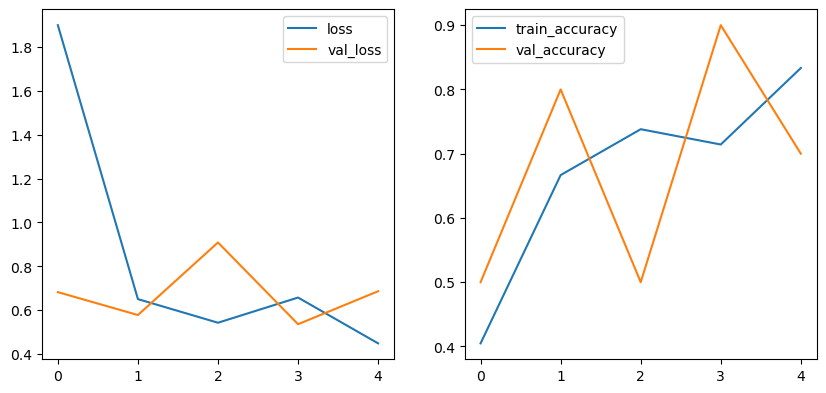

In [23]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.legend()

plt.subplot(222)
plt.plot(hist.history['accuracy'],label='train_accuracy')
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.legend()

# VGG16

In [33]:
base_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
base_model.trainable = False

x = Flatten()(base_model.layers[-1].output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64,  activation='relu')(x)

output = Dense(1, activation='sigmoid')(x)

vgg_model = Model(inputs = base_model.inputs, outputs = output)

In [34]:
vgg_model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint_path = f"vgg16.h5"

callbacks = [
    EarlyStopping(patience=5),
    ModelCheckpoint(checkpoint_path, save_best_only=True)
]

history = vgg_model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=15, verbose=1,
                    callbacks=callbacks
                    )

Epoch 1/15
11/11 [==============================] - 5s 334ms/step - loss: 60.7491 - accuracy: 0.5714 - val_loss: 2.0873 - val_accuracy: 0.8000
Epoch 2/15
11/11 [==============================] - 3s 281ms/step - loss: 3449.5398 - accuracy: 0.7143 - val_loss: 99.5534 - val_accuracy: 0.6000
Epoch 3/15
11/11 [==============================] - 3s 321ms/step - loss: 459.9455 - accuracy: 0.8095 - val_loss: 1343.6500 - val_accuracy: 0.7000
Epoch 4/15
11/11 [==============================] - 3s 299ms/step - loss: 226.2656 - accuracy: 0.7619 - val_loss: 1.2819 - val_accuracy: 0.9000
Epoch 5/15
11/11 [==============================] - 3s 283ms/step - loss: 126.9603 - accuracy: 0.7143 - val_loss: 2937.8647 - val_accuracy: 0.8000
Epoch 6/15
11/11 [==============================] - 3s 279ms/step - loss: 3.1232 - accuracy: 0.8571 - val_loss: 7842.0342 - val_accuracy: 0.8000
Epoch 7/15
11/11 [==============================] - 3s 301ms/step - loss: 776.4301 - accuracy: 0.8810 - val_loss: 1.5984e-04 - v

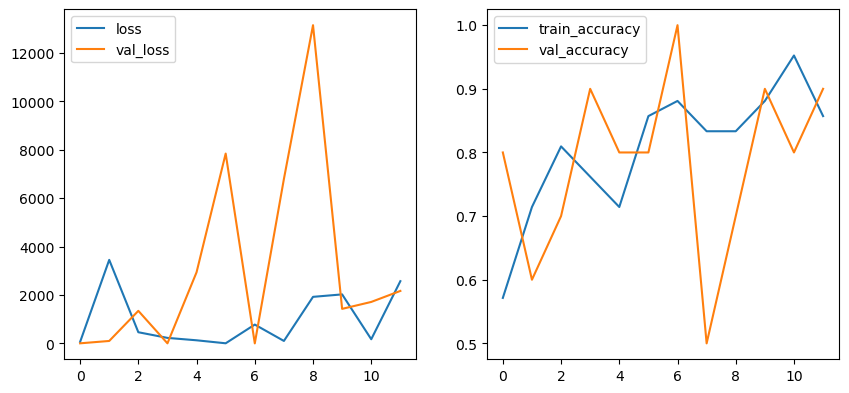

In [35]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

plt.subplot(222)
plt.plot(history.history['accuracy'],label='train_accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()

# Load Test Images


1. Use the same ImageDataGenerator class to ensure same preprocessing
1. Specify the same target image size as the training generator
1. Include the rescaling parameter to normalize pixel values
1. Omit the data augmentation


In [9]:
test_path = '/kaggle/input/imagedatamodified/ImageDatasetModified/Test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_data_generator = test_datagen.flow_from_directory(
  test_path,
  target_size=(224, 224),
  batch_size=batch_size,
  class_mode='binary',
  shuffle=False)

Found 8 images belonging to 2 classes.


1/1 [==============================] - 1s 939ms/step


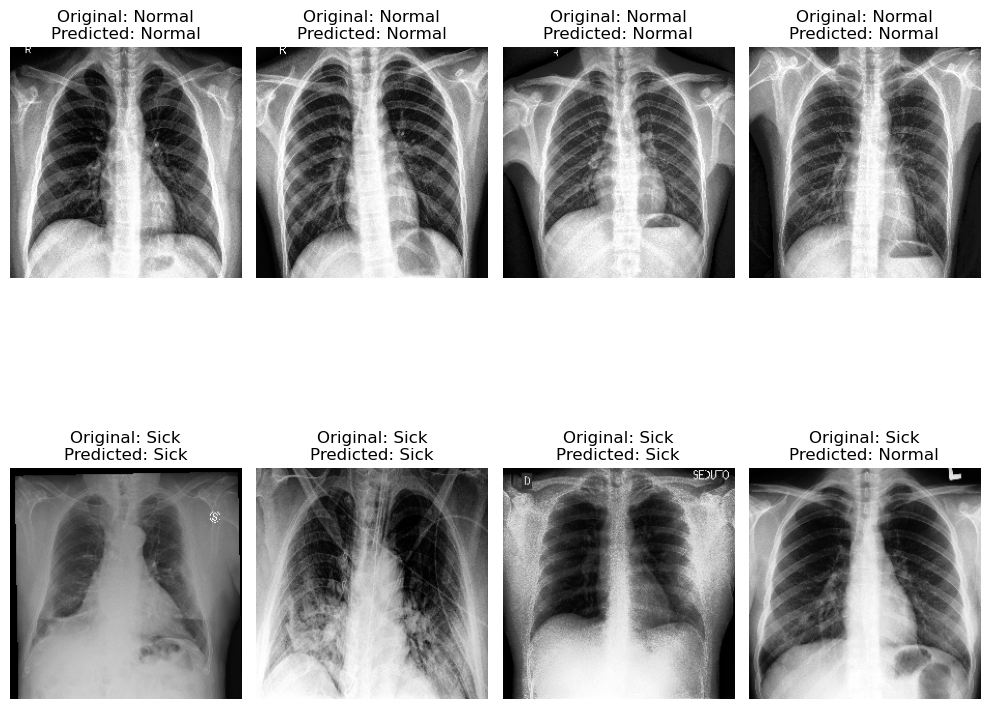

In [10]:
# Get 4 normal images
test_imgs_normal, test_labels_normal = next(test_data_generator) 

# Get 4 sick images
test_imgs_sick, test_labels_sick = next(test_data_generator)

# Combine them
test_imgs = np.concatenate((test_imgs_normal, test_imgs_sick))
test_labels = np.concatenate((test_labels_normal, test_labels_sick))

preds = vgg_model.predict(test_imgs)
pred_labels = (preds > 0.5).astype('int')

# Plot predictions
plt.figure(figsize=(10,10))
for i in range(len(test_imgs)):
  img = test_imgs[i]  
  orig_label = 'Sick' if test_labels[i]==1 else 'Normal'
  pred_label = 'Sick' if pred_labels[i]==1 else 'Normal'
  
  plt.subplot(2,4,i+1)
  plt.imshow(img)
  plt.title(f'Original: {orig_label}\nPredicted: {pred_label}')
  plt.axis('off')

plt.tight_layout()
plt.show()

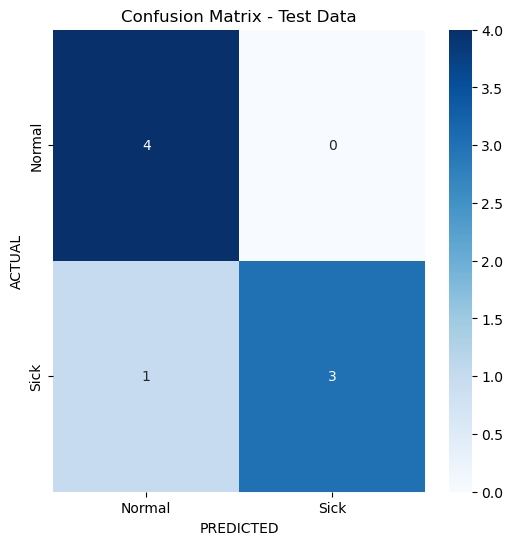

In [14]:
# Get true and predicted labels
y_true = test_labels
y_pred = pred_labels

cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Sick'], yticklabels=['Normal', 'Sick'])
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.title('Confusion Matrix - Test Data')
plt.show()

In [15]:
from sklearn.metrics import precision_recall_fscore_support

# Get true and predicted labels 
y_true = test_labels  
y_pred = pred_labels

precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-score: {:.3f}".format(fscore))

cm = confusion_matrix(y_true, y_pred)
accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
print("Accuracy: {:.3f}".format(accuracy))

Precision: 1.000
Recall: 0.750
F1-score: 0.857
Accuracy: 0.875


# Grid Search to Evalute the Best Parameters

Adam lr =0.001

The above model finished learning
Adam lr =0.0001

The above model finished learning
Adam lr =0.01

The above model finished learning
RMSprop lr =0.001

The above model finished learning
RMSprop lr =0.0001

The above model finished learning
RMSprop lr =0.01

The above model finished learning
SGD lr =0.001

The above model finished learning
SGD lr =0.0001

The above model finished learning
SGD lr =0.01

The above model finished learning


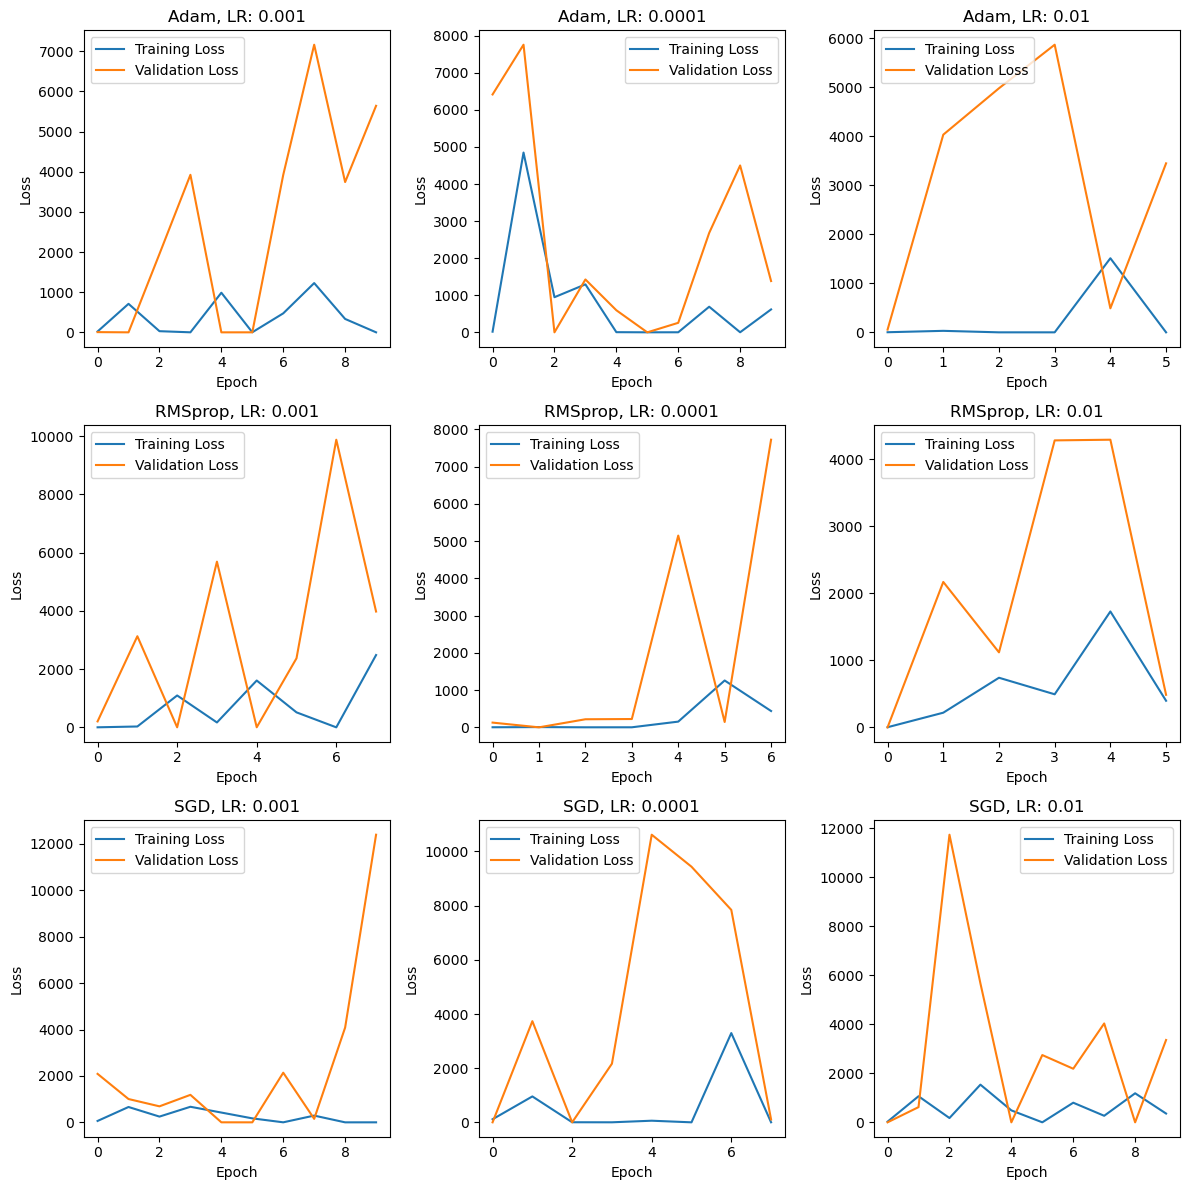


Best Model by Minimum Validation Loss:
Learning Rate: 0.0001
Optimizer: Adam


In [5]:
optimizers = ['Adam', 'RMSprop', 'SGD']
learning_rates = [1e-3, 1e-4, 1e-2]
train_losses = []
val_losses = []
all_train_losses = []
all_val_losses = []

best_model_loss = float('inf')
best_learning_rate = 0.0

for optimizer in optimizers:
    optimizer_train_losses = []
    optimizer_val_losses = []
    all_optimizer_train_losses = []
    all_optimizer_val_losses = []
    
    for learning_rate in learning_rates:
        
        weights= '/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

        base_model = VGG16(input_shape=(224, 224, 3), weights=weights, include_top=False)
        base_model.trainable = False

        x = Flatten()(base_model.layers[-1].output)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(64,  activation='relu')(x)
        output = Dense(1, activation='sigmoid')(x)

        model = Model(inputs = base_model.inputs, outputs = output)

        # Compile the model with the current optimizer and learning rate
        if optimizer == 'Adam':
            optimizer_instance = Adam(learning_rate=learning_rate)
            print(f"{optimizer} lr ={learning_rate}")
        elif optimizer == 'RMSprop':
            optimizer_instance = RMSprop(learning_rate=learning_rate)
            print(f"{optimizer} lr ={learning_rate}")
        elif optimizer == 'SGD':
            optimizer_instance = SGD(learning_rate=learning_rate)
            print(f"{optimizer} lr ={learning_rate}")
        
        model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        checkpoint_path = f"vgg16_{optimizer}_{learning_rate}.ckpt"

        callbacks = [
            EarlyStopping(patience=5),
            ModelCheckpoint(checkpoint_path, save_best_only=True)
        ]

        history = model.fit(train_generator,
                            validation_data=validation_generator,
                            epochs=10, verbose=0,
                            callbacks=callbacks
                            )
        print('\nThe above model finished learning')
        
        optimizer_train_losses.append(min(history.history['loss']))
        optimizer_val_losses.append(min(history.history['val_loss']))
        all_optimizer_train_losses.append(history.history['loss'])
        all_optimizer_val_losses.append(history.history['val_loss'])
        
        if min(history.history['val_loss']) < best_model_loss:
            best_model_loss = min(history.history['val_loss'])
            best_learning_rate = learning_rate
            best_optimizer = optimizer
            
    train_losses.append(optimizer_train_losses)
    val_losses.append(optimizer_val_losses)
    all_train_losses.append(all_optimizer_train_losses)
    all_val_losses.append(all_optimizer_val_losses)
    
# Plot the validation curves for each optimizer
# plt.figure(figsize=(10, 6))
# plt.title("Validation Curves for Different Optimizers")
# plt.xlabel("Learning Rate")
# plt.ylabel("Loss")

# for i, optimizer in enumerate(optimizers):
#     plt.semilogx(learning_rates, train_losses[i], label=f"{optimizer} Training loss")
#     plt.semilogx(learning_rates, val_losses[i], label=f"{optimizer} Validation loss")

# plt.legend(loc="best")
# plt.show()

# Plotting the learning curves for each optimizer and learning rate
fig, axs = plt.subplots(len(optimizers), len(learning_rates), figsize=(12, 12))

for i, optimizer in enumerate(optimizers):
    for j, learning_rate in enumerate(learning_rates):
        axs[i, j].plot(all_train_losses[i][j], label='Training Loss')
        axs[i, j].plot(all_val_losses[i][j], label='Validation Loss')
        axs[i, j].set_title(f"{optimizer}, LR: {learning_rate}")
        axs[i, j].set_xlabel('Epoch')
        axs[i, j].set_ylabel('Loss')
        axs[i, j].legend()

plt.tight_layout()
plt.show()


print("\nBest Model by Minimum Validation Loss:")
print("Learning Rate:", best_learning_rate)
print("Optimizer:", best_optimizer)